# Telco Customer Churn — **02_Modeling_Interpretation**
*Prepared 2025-11-04 09:25 (WIB)*  
*Author: Hans Christian*

**Goal:** Build robust churn models with clear business interpretation.


## Block 0 — Setup & Paths

In [1]:
!pip -q install imbalanced-learn xgboost shap

In [2]:
# --- Imports dulu (sebelum pakai os) ---
import os, joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import matplotlib.pyplot as plt

# --- Colab mount & base path ---
try:
    from google.colab import drive  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    drive.mount('/content/drive')
    BASE = '/content/drive/MyDrive/Portofolio/1_Telco_Customer_Churn'
else:
    BASE = '/content/drive/MyDrive/Portofolio/1_Telco_Customer_Churn'  # sesuaikan jika lokal

CLEAN_FILE = f"{BASE}/data_clean/churn_clean.csv"
MODEL_DIR  = f"{BASE}/models"
os.makedirs(MODEL_DIR, exist_ok=True)

# --- Load data bersih ---
df = pd.read_csv(CLEAN_FILE)
print(df.shape)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Block 1 — Feature Split & Preprocess

In [3]:

y = df["Churn"].map({"Yes":1, "No":0}).astype(int)
X = df.drop(columns=["Churn", "customerID"], errors="ignore")

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include="object").columns.tolist()

pre = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (5634, 19) Test: (1409, 19)


## Block 2 — Baseline: Logistic Regression (with SMOTE)

              precision    recall  f1-score   support

           0     0.9060    0.7169    0.8004      1035
           1     0.5034    0.7941    0.6162       374

    accuracy                         0.7374      1409
   macro avg     0.7047    0.7555    0.7083      1409
weighted avg     0.7991    0.7374    0.7515      1409

ROC AUC: 0.8402206205275259


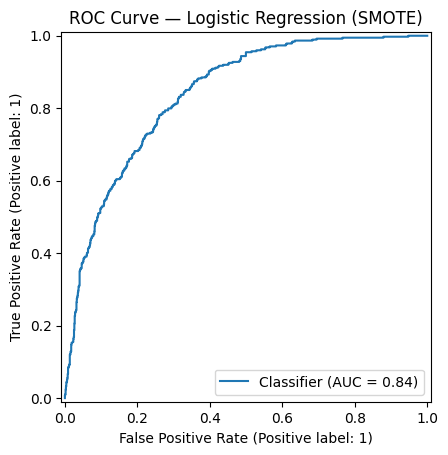

Saved model: /content/drive/MyDrive/Portofolio/1_Telco_Customer_Churn/models/logreg_smote.joblib


In [4]:

pipe = ImbPipeline(steps=[
    ("pre", pre),
    ("smote", SMOTE(random_state=42)),
    ("clf", LogisticRegression(max_iter=200, n_jobs=None))
])

pipe.fit(X_train, y_train)
preds = pipe.predict(X_test)
proba = pipe.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds, digits=4))
print("ROC AUC:", roc_auc_score(y_test, proba))

RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve — Logistic Regression (SMOTE)")
plt.show()

joblib.dump(pipe, f"{MODEL_DIR}/logreg_smote.joblib")
print("Saved model:", f"{MODEL_DIR}/logreg_smote.joblib")


## Block 3 — Gradient Boosting (XGBoost)

              precision    recall  f1-score   support

           0     0.8523    0.8473    0.8498      1035
           1     0.5842    0.5936    0.5889       374

    accuracy                         0.7800      1409
   macro avg     0.7182    0.7205    0.7193      1409
weighted avg     0.7811    0.7800    0.7805      1409

ROC AUC: 0.8286096256684492


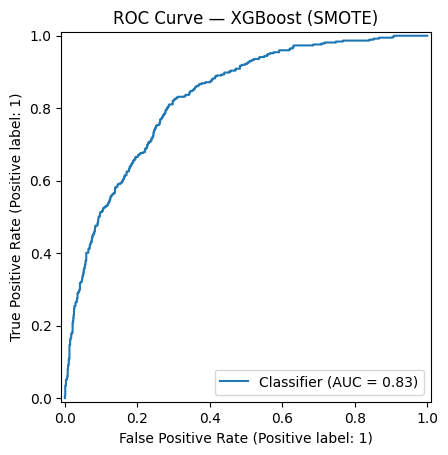

Saved model: /content/drive/MyDrive/Portofolio/1_Telco_Customer_Churn/models/xgb_smote.joblib


In [5]:

from xgboost import XGBClassifier

xgb = ImbPipeline(steps=[
    ("pre", pre),
    ("smote", SMOTE(random_state=42)),
    ("clf", XGBClassifier(
        n_estimators=400, max_depth=4, learning_rate=0.08, subsample=0.9, colsample_bytree=0.9,
        reg_lambda=1.0, random_state=42, eval_metric="logloss", n_jobs=-1
    ))
])

xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)
proba = xgb.predict_proba(X_test)[:,1]

print(classification_report(y_test, preds, digits=4))
print("ROC AUC:", roc_auc_score(y_test, proba))
RocCurveDisplay.from_predictions(y_test, proba)
plt.title("ROC Curve — XGBoost (SMOTE)")
plt.show()

joblib.dump(xgb, f"{MODEL_DIR}/xgb_smote.joblib")
print("Saved model:", f"{MODEL_DIR}/xgb_smote.joblib")


## Block 4 — Explainability SHAP KernelExplainer

  0%|          | 0/100 [00:00<?, ?it/s]

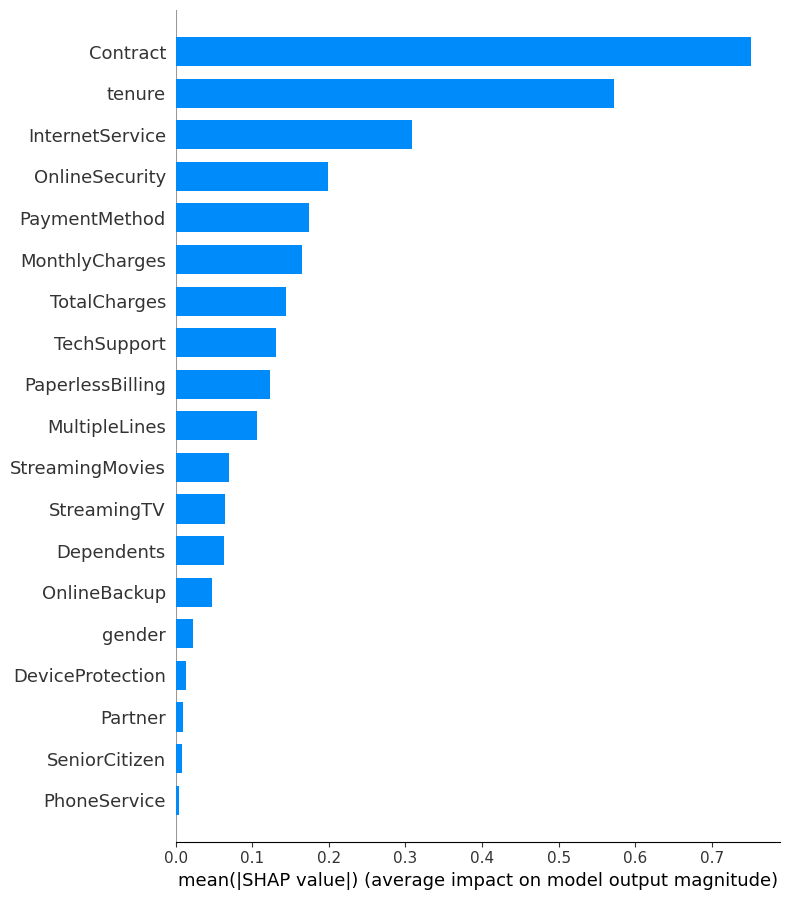

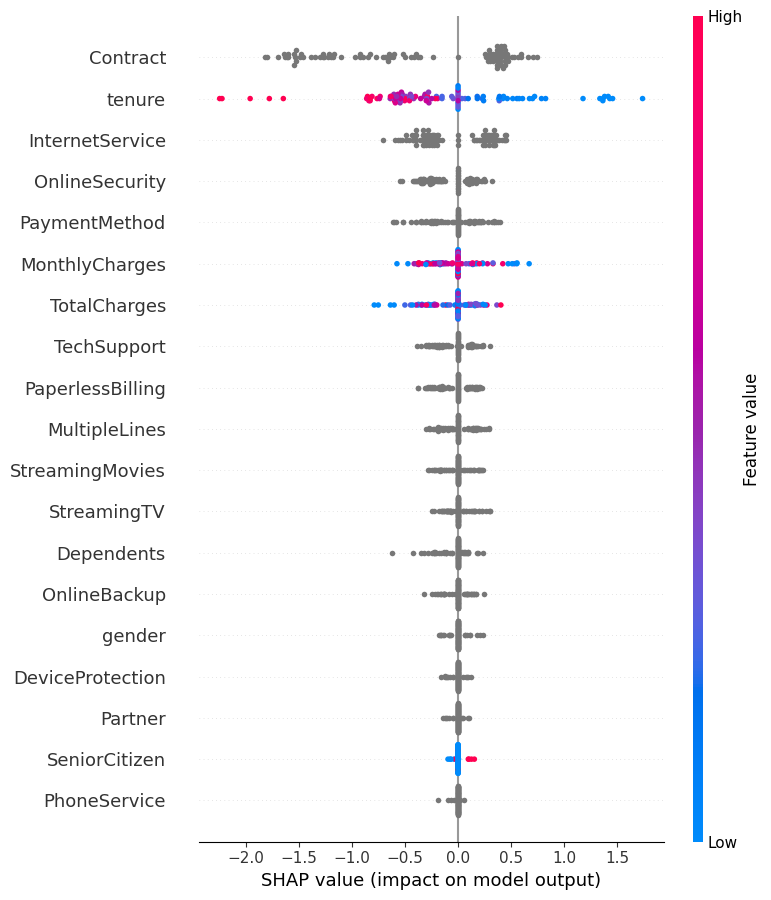

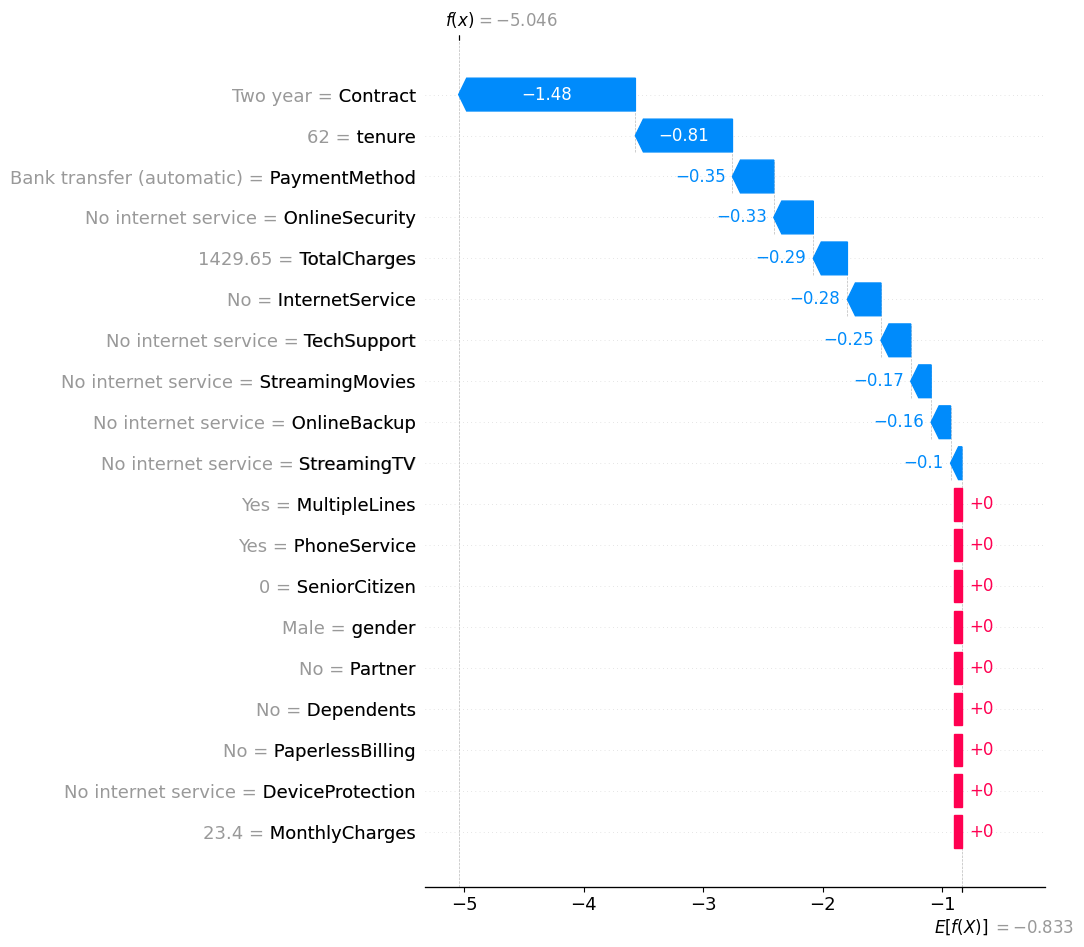

Done. Kernel SHAP berjalan (subset). Kamu bisa ubah bg_n/test_n/nsamples untuk akurasi vs kecepatan.


In [6]:
# --- Block 4 — Explainability (SHAP KernelExplainer, stable) ---

# 0) Install (sekali saja di atas notebook kalau belum)
# !pip -q install shap

import shap, numpy as np, pandas as pd
import matplotlib.pyplot as plt

# 1) Fungsi prediksi proba dari PIPELINE pada RAW FEATURES
#    (KernelExplainer akan memanggil fungsi ini berulang)
def predict_proba_raw(Xraw: np.ndarray):
    Xdf = pd.DataFrame(Xraw, columns=X_train.columns)  # pastikan kolom sama urutan
    return xgb.predict_proba(Xdf)[:, 1]                # pipeline xgb -> proba kelas "churn=1"

# 2) Pilih background sample kecil agar cepat (representatif)
rng = np.random.default_rng(42)
bg_n   = min(200, len(X_train))
test_n = min(100, len(X_test))

bg_idx    = rng.choice(X_train.index, size=bg_n, replace=False)
test_idx  = rng.choice(X_test.index,  size=test_n, replace=False)

X_bg    = X_train.loc[bg_idx].copy()
X_testS = X_test.loc[test_idx].copy()

# 3) Buat KernelExplainer (gunakan link='logit' biar selaras dengan proba)
explainer = shap.KernelExplainer(predict_proba_raw, X_bg, link="logit")

# 4) Hitung SHAP values untuk subset test
#    nsamples: makin besar makin akurat namun lebih lambat (100–300 biasanya cukup)
shap_values = explainer.shap_values(X_testS, nsamples=200)

# 5) Summary plot (bar & beeswarm) — GLOBAL importance
shap.summary_plot(shap_values, X_testS, plot_type="bar", show=True)
shap.summary_plot(shap_values, X_testS, show=True)

# 6) Waterfall untuk SATU pelanggan (LOCAL explanation)
i = 0  # ganti index lokal yang ingin kamu jelaskan
shap.waterfall_plot(shap.Explanation(
    values=shap_values[i],
    base_values=explainer.expected_value,
    data=X_testS.iloc[i],
    feature_names=X_testS.columns
), max_display=20)
plt.show()

print("Done. Kernel SHAP berjalan (subset). Kamu bisa ubah bg_n/test_n/nsamples untuk akurasi vs kecepatan.")

## 🧭 Block 5 — Business Interpretation & What-If

- Tulis insight utama: siapa yang berisiko churn? (contract=month-to-month, tenure rendah, charges tinggi, dsb.)
- Rekomendasi: diskon/retention offer untuk segmen risiko tinggi; auto-flag ke CRM; A/B test untuk konfirmasi dampak.


In [7]:
!pip -q install streamlit shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 115.2 MB/s eta 0:00:00


In [8]:
%cd "/content/drive/MyDrive/Portofolio/1_Telco Customer Churn/dashboard"
!streamlit run churn_dashboard_app.py --server.port 8501 --server.address 0.0.0.0

[Errno 2] No such file or directory: '/content/drive/MyDrive/Portofolio/1_Telco Customer Churn/dashboard'
/content
Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: churn_dashboard_app.py


In [9]:
# Jalankan Streamlit dengan auto-deteksi External URL
!nohup streamlit run churn_dashboard_app.py --server.port 8501 --server.address 0.0.0.0 & sleep 5 && grep -o 'https://[0-9a-zA-Z.-]*\.gradio\.live' nohup.out

nohup: appending output to 'nohup.out'


In [10]:
!grep -o 'https://[0-9a-zA-Z.-]*\.gradio\.live' nohup.out